In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
def one_hot(y, num_classes=10):
    encoded = np.zeros((len(y), num_classes))
    encoded[np.arange(len(y)), y] = 1
    return encoded


def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    return (x > 0).astype(float)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def softmax(z):
    expz = np.exp(z - np.max(z, axis=1, keepdims=True))
    return expz / np.sum(expz, axis=1, keepdims=True)


def cross_entropy(y_true, y_pred):
    m = len(y_true)
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

In [3]:
class SimpleNeuralNet:

    def __init__(self, input_dim, h1, h2, output_dim, lr=0.1, activation="relu"):
        self.lr = lr
        self.activation_name = activation

     
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, output_dim) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, output_dim))

    def activation(self, x):
        return relu(x) if self.activation_name == "relu" else sigmoid(x)

    def activation_grad(self, x):
        return relu_grad(x) if self.activation_name == "relu" else (self.activation(x) * (1 - self.activation(x)))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.activation(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.activation(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = softmax(self.Z3)

        return self.A3

    def backward(self, X, Y):
        m = len(X)

        dZ3 = self.A3 - Y
        dW3 = (self.A2.T @ dZ3) / m
        db3 = np.mean(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * self.activation_grad(self.Z2)
        dW2 = (self.A1.T @ dZ2) / m
        db2 = np.mean(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.activation_grad(self.Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.mean(dZ1, axis=0, keepdims=True)

   
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

In [4]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X = X / 255.0
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

Y_train = one_hot(y_train)

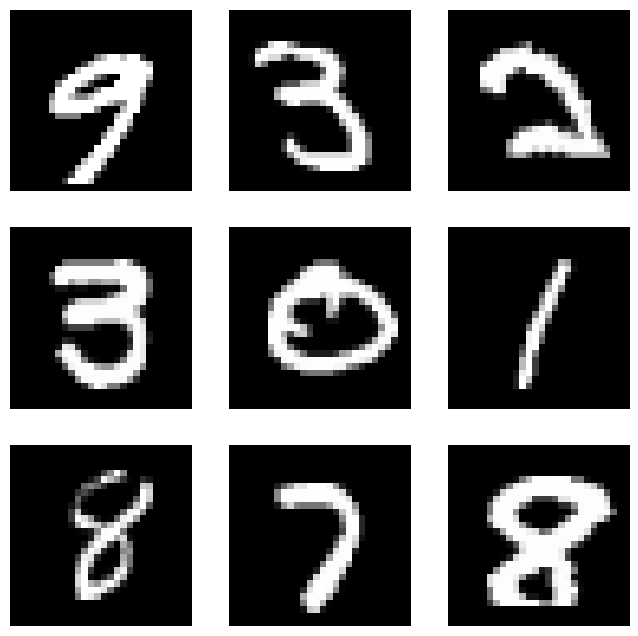

In [5]:
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap="gray")
    plt.axis('off')
plt.show()

In [6]:
model = SimpleNeuralNet(
    input_dim=784,
    h1=128,
    h2=64,
    output_dim=10,
    lr=0.05,
    activation="relu"
)

In [7]:
losses = []
accs = []

batch_size = 64
epochs = 25

for epoch in range(epochs):

    permutation = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[permutation]
    Y_shuffled = Y_train[permutation]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]

        probs = model.forward(X_batch)
        model.backward(X_batch, Y_batch)

    probs_full = model.forward(X_train)
    loss = cross_entropy(Y_train, probs_full)

    preds = model.predict(X_test)
    acc = np.mean(preds == y_test)

    losses.append(loss)
    accs.append(acc)   

    print(f"Epoch {epoch+1}/{epochs} | Loss={loss:.4f} | Accuracy={acc*100:.2f}%")

Epoch 1/25 | Loss=0.2538 | Accuracy=92.13%
Epoch 2/25 | Loss=0.1727 | Accuracy=94.69%
Epoch 3/25 | Loss=0.1285 | Accuracy=95.71%
Epoch 4/25 | Loss=0.1069 | Accuracy=96.09%
Epoch 5/25 | Loss=0.0940 | Accuracy=96.24%
Epoch 6/25 | Loss=0.0761 | Accuracy=96.69%
Epoch 7/25 | Loss=0.0635 | Accuracy=96.99%
Epoch 8/25 | Loss=0.0663 | Accuracy=96.66%
Epoch 9/25 | Loss=0.0544 | Accuracy=96.93%
Epoch 10/25 | Loss=0.0479 | Accuracy=97.10%
Epoch 11/25 | Loss=0.0401 | Accuracy=97.37%
Epoch 12/25 | Loss=0.0374 | Accuracy=97.44%
Epoch 13/25 | Loss=0.0361 | Accuracy=97.34%
Epoch 14/25 | Loss=0.0308 | Accuracy=97.43%
Epoch 15/25 | Loss=0.0286 | Accuracy=97.52%
Epoch 16/25 | Loss=0.0223 | Accuracy=97.58%
Epoch 17/25 | Loss=0.0224 | Accuracy=97.67%
Epoch 18/25 | Loss=0.0189 | Accuracy=97.48%
Epoch 19/25 | Loss=0.0175 | Accuracy=97.59%
Epoch 20/25 | Loss=0.0226 | Accuracy=97.28%
Epoch 21/25 | Loss=0.0155 | Accuracy=97.55%
Epoch 22/25 | Loss=0.0130 | Accuracy=97.59%
Epoch 23/25 | Loss=0.0120 | Accuracy=97.6

In [8]:
print(f"Final Test Accuracy: {acc*100:.2f}%")

Final Test Accuracy: 97.53%


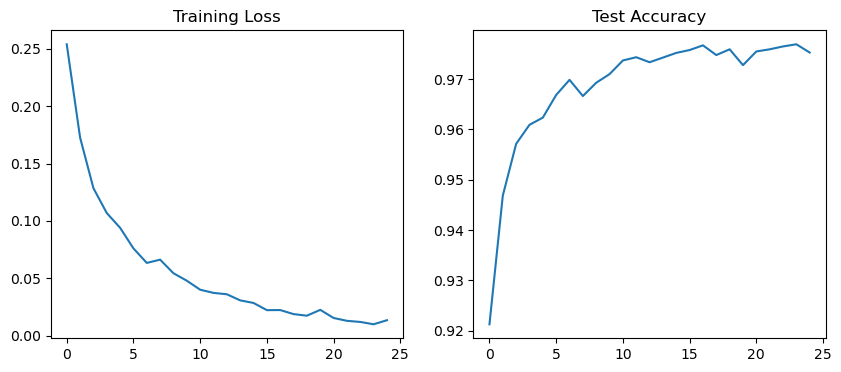

In [9]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Test Accuracy")

plt.show()

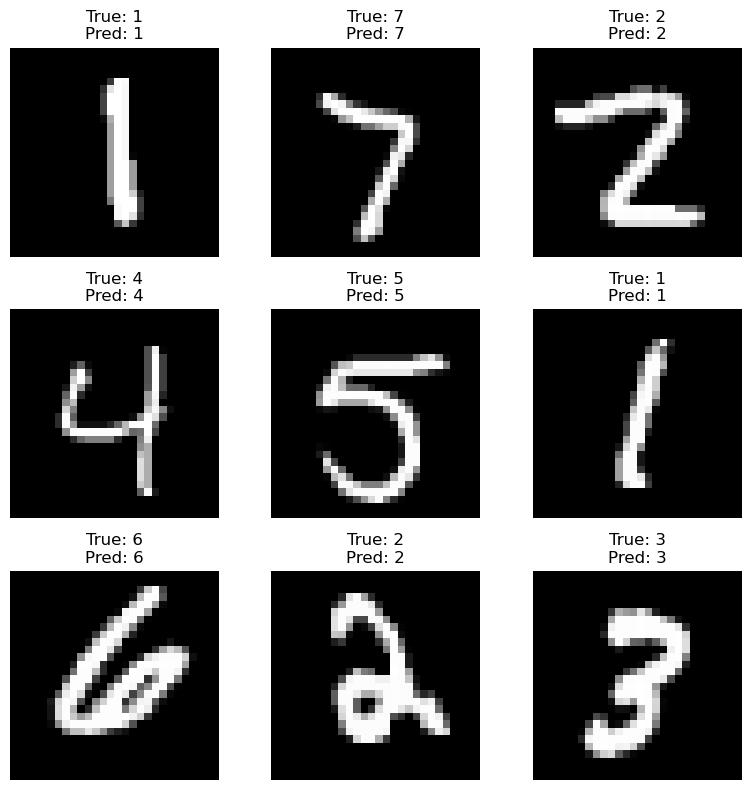

In [11]:
import random

indices = random.sample(range(len(X_test)), 9)
sample_images = X_test[indices]
sample_labels = y_test[indices]
sample_preds = model.predict(sample_images)

plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i].reshape(28,28), cmap="gray")
    plt.title(f"True: {sample_labels[i]}\nPred: {sample_preds[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()